In [1]:
import os
from tvb.simulator.lab import *
import numpy as np
import seaborn
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io
LOG = get_logger('demo')
import pickle as cPickle
from tvb.simulator.models.stefanescu_jirsa import ReducedSetHindmarshRose
from os.path import join as pjoin
from sklearn import preprocessing

/Users/yilewang/miniconda3/envs/tvbenv/lib/python3.11/site-packages/tvb/datatypes/surfaces.py:60: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)


### General workflow of data analyses

1. load fmri simulation
2. calculate the fc then calculate the correlation between simulated fc and empirical fc
3. save the correlation coefficient then plot the correlation trajectory for each participant
4. visualize the results

In [2]:
base_dir = "/Users/yilewang/Downloads/"
data_dir = pjoin(base_dir, "local_inhibition")

eFC_dir = "/Users/yilewang/workspaces/data4project/lateralization/ts_fmri/fmri_AAL_16"

def FC_fitting(group, caseid, K21, dir):
    subj_dir = pjoin(dir, group, caseid+'_'+str(K21)+'.csv')
    s_ts = pd.read_csv(subj_dir)
    # calculate the simulated FC
    s_fc = s_ts.corr()
    # compare it to the empirical FC
    mat = scipy.io.loadmat(pjoin(eFC_dir, group+"-TS", caseid, "ROISignals_"+caseid+'.mat'))
    e_ts = pd.DataFrame(mat['ROISignals'])
    e_fc = e_ts.corr()
    # vectorize the lower triangle of the matrix
    s_fc_vec = np.tril(s_fc, k=-1).flatten()
    s_fc_vec = s_fc_vec[np.nonzero(s_fc_vec)[0]]
    e_fc_vec = np.tril(e_fc, k=-1).flatten()
    e_fc_vec = e_fc_vec[np.nonzero(e_fc_vec)[0]]
    # calculate the correlation coefficienv
    # s_fc_vec_nor = preprocessing.normalize(np.array(s_fc_vec).reshape(-1,1))[:,0]
    # e_fc_vec_nor = preprocessing.normalize(np.array(e_fc_vec).reshape(-1,1))[:,0]
    corr = np.corrcoef(s_fc_vec, e_fc_vec)[0,1]
    # iterate then I can have a plot for inidividuals.
    return corr

In [3]:
# read mega data
mega_data = pd.read_excel('/Users/yilewang/workspaces/data4project/mega_table.xlsx', sheet_name='tvb_parameters')

# create a dataframe for all subjects
local_inhibition = pd.DataFrame(columns=['group', 'caseid', 'highest_K21', 'highest_corr'])
for i, j, go in zip(mega_data.group, mega_data.caseid, mega_data.Go):
    k_corr = []
    for k in np.arange(0.001, 0.1, 0.001):
        k = round(k, 3)
        corr = FC_fitting(i, j, k, data_dir)
        k_corr.append(corr)
    # find the highest correlation coefficient
    if len(k_corr)>0:
        highest_K21 = np.arange(0.001, 0.1, 0.001)[np.argmax(k_corr)]
        highest_corr = np.max(k_corr)
        local_inhibition.loc[len(local_inhibition)] = [i, j, highest_K21, highest_corr]
    else:
        pass
    # if len(k_corr)>0:
    #     plt.plot(k_corr)
    #     plt.title(f"{i}_{j}")
    #     # set the y-axis limit
    #     plt.show()
    # else:
    #     pass

In [4]:
print(local_inhibition)
local_inhibition.to_csv(pjoin(data_dir, 'local_inhibition.csv'), index=False)

   group caseid  highest_K21  highest_corr
0    SNC  2820A        0.026      0.128536
1    SNC  3168A        0.062      0.341358
2    SNC  3358A        0.067      0.166685
3    SNC  3610A        0.054      0.310443
4    SNC  4073A        0.048      0.123396
..   ...    ...          ...           ...
69    AD  3255A        0.051      0.193609
70    AD  4612A        0.046      0.361279
71    AD  5368A        0.097      0.178218
72    AD  5571A        0.055      0.368780
73    AD  7673A        0.057      0.553981

[74 rows x 4 columns]


<Axes: xlabel='group', ylabel='highest_K21'>

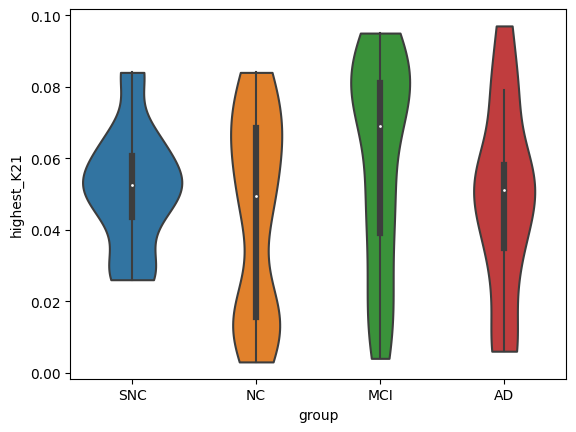

In [5]:
# plot the distribution of highest_K21 across different groups
seaborn.violinplot(x='group', y='highest_K21', data=local_inhibition, cut=0, bw=.4)

<Axes: xlabel='group', ylabel='highest_corr'>

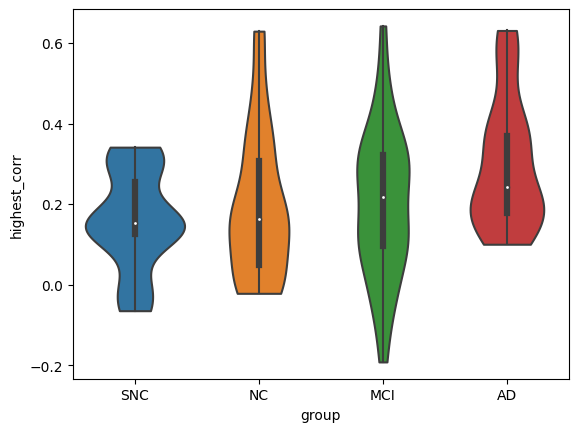

In [6]:
seaborn.violinplot(x='group', y='highest_corr', data=local_inhibition, cut=0, bw=0.4)

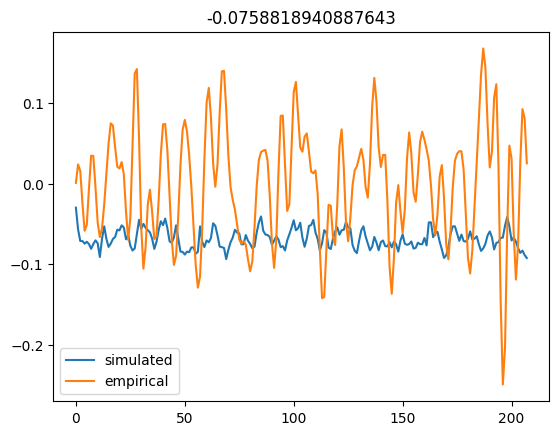

In [7]:
channel = 15
# check individual cases
group = "MCI"
caseid = "0578A"
K21 = local_inhibition[(local_inhibition.group==group) & (local_inhibition.caseid==caseid)].highest_K21.values[0]
case_path = pjoin(data_dir, group, caseid+'_'+str(K21)+'.csv')
case_ts = pd.read_csv(case_path)
# plot time series of all nodes
s_ts = preprocessing.normalize(np.array(case_ts.iloc[:,channel]).reshape(1,-1))
plt.plot(s_ts[0,:], label='simulated')



# empirical FC
mat = scipy.io.loadmat(pjoin(eFC_dir, group+"-TS", caseid, "ROISignals_"+caseid+'.mat'))
e_ts = pd.DataFrame(mat['ROISignals'])
e_ts = preprocessing.normalize(np.array(e_ts.iloc[:,channel]).reshape(1,-1))
plt.plot(e_ts[0,:], label='empirical')
plt.legend()
plt.title(f"{np.corrcoef(e_ts[0,:], s_ts[0,:])[0, 1]}")
plt.show()

